# 2. Monolithic AD & ML Approaches and Why They are Unsatisfactory

Given the abundance of normal driving data, the problem naturally leads to an anomaly detection (AD) formulation. Let’s try some off-the-shell well-known methods for example Isolation Forest!

In theory, AD approach isn't affected by the Cold Start problem as training data is normal data only, and is hence we only need labels during evaluation of the intrusion detection system.

But will it work accurately enough? Let's try!

### 2a. A naive AD approach using IsolationForest

In [6]:
SENSORS = ["SteeringAngle", "CarSpeed", "YawRate", "Gx", "Gy"]

def compute_timediff_fillna(df):
    df = df.copy()
    for s in SENSORS:
        sensor_not_isna = df[~df[s].isna()]
        df["%s_TimeDiff" % s] = sensor_not_isna.Timestamp - sensor_not_isna.shift(1).Timestamp
    #print(df.head(20))

    for s in SENSORS:
        df[s] = df[s].fillna(method="ffill")
        df["%s_TimeDiff" % s] = df["%s_TimeDiff" % s].fillna(method="ffill")
    df.dropna(inplace=True)
    
    return df

df = pd.read_parquet("%s/train/attacks/20181113_Driver1_Trip1-0.parquet" % DATA_LOCATION)
df = compute_timediff_fillna(df)

Since we know that message timing is important, we should try to use those features in AD training. Can you spot see the difference between normal vs attack messages?

In [8]:
df_normal = df[df.Label == 'Normal']
df_normal.sample(5)

Timestamp  SteeringAngle    CarSpeed    YawRate        Gx        Gy  \
310314  4651.368009       1.599472   53.262020   0.182120  0.036140 -0.104073   
219474  2693.819987       4.386408   80.489037  17.014353 -0.013549 -0.894699   
122275  2055.612012       4.283608   46.228298   1.063028  0.140284 -0.336961   
211727  2660.735991       4.903600   78.351761   1.506351  0.139225 -0.308420   
422124  6371.280012      15.572001  128.386993   4.926676  0.101201  3.130639   

         Label  SteeringAngle_TimeDiff  CarSpeed_TimeDiff  YawRate_TimeDiff  \
310314  Normal                0.011984           0.024000          0.011943   
219474  Normal                0.011960           0.024007          0.010611   
122275  Normal                0.012026           0.023980          0.000028   
211727  Normal                0.011992           0.023992          0.011897   
422124  Normal                0.011982           0.024007          0.009422   

        Gx_TimeDiff  Gy_TimeDiff  
310314     0.011943     0.011943  
219474     0.012002     0.012002  
122275     0.012044     0.012044  
211727     0.011897     0.011897  
422124     0.011985     0.011985

In [9]:
df_attack = df[df.Label == 'Attack']
df_attack.sample(5)

Timestamp  SteeringAngle    CarSpeed    YawRate        Gx        Gy  \
467242  7426.091304        1.01600  130.722397  40.000000 -0.173196 -0.056015   
64307    769.020065        2.41600   73.692062   0.446286  0.295156  0.314811   
208178  2647.740008        0.26960   79.171234   0.024701 -0.010674  0.148819   
282899  3998.520016        2.48938   57.042484   0.339417  0.352549 -0.127944   
255545  3470.351199        2.53278    0.000000   0.523398  0.003199  0.010731   

         Label  SteeringAngle_TimeDiff  CarSpeed_TimeDiff  YawRate_TimeDiff  \
467242  Attack                0.012003           0.024005          0.011349   
64307   Attack                0.011996           0.024002          0.000009   
208178  Attack                0.011999           0.023980          0.000007   
282899  Attack                0.012006           0.024000          0.000003   
255545  Attack                0.011987           0.023975          0.011168   

        Gx_TimeDiff  Gy_TimeDiff  
467242     0.011985     0.011985  
64307      0.000009     0.000009  
208178     0.000007     0.000007  
282899     0.000003     0.000003  
255545     0.012055     0.012055

In [10]:
from sklearn.ensemble import IsolationForest
import sklearn.metrics

FEATURES = SENSORS + ["%s_TimeDiff" % s for s in SENSORS]

iforest = IsolationForest(n_estimators=500).fit(df_normal[FEATURES])

In [11]:
df2 = pd.read_parquet("%s/train/attacks/20181203_Driver1_Trip10-20.parquet" % DATA_LOCATION)
df2 = compute_timediff_fillna(df2)

ypred = iforest.predict(df2[FEATURES])
ypred = pd.Series(np.maximum(-ypred, 0))

cf = sklearn.metrics.confusion_matrix(df2.Label == "Attack", ypred)
print(cf) 

print("Accuracy = %s " % sklearn.metrics.accuracy_score(df2.Label =="Attack", ypred))

[[37486  6257]
 [ 4102  3858]]
Accuracy = 0.7996441212308764 


This is certainly not bad for a start. But the TPR and FPR is no where near what’s needed for deployment!

While there are a lot of exciting approaches for AD and sequential time-series data, including using RNN/LSTM/CNN, autoencoders, self-supervised learning, etc. The fundamental problem with AD is that it is hard to achieve high TPR while simultaneously achieving very low FPR.

Since AD after all, is a harder problem than supervised learning and while they are important parts of the tool box, we still need final human clearance to key system decisions.

### 2b. Machine teaching: leveraging ML to "program" a classifier by specifying human-generated outputs

If we zoom in, it is perhaps easier to see the zig-zag patterns of alternating real vs injected messages. It's clear that perhaps we can leverage a ML to classify these kinds of smooth vs zig-zag patterns.

After all, ML should excel at pattern recognition.

The significance of this approach is that it is much easier for human experts to synthesize the attack data than to write the detection program. And such is the promise of Software 2.0, but will it work?

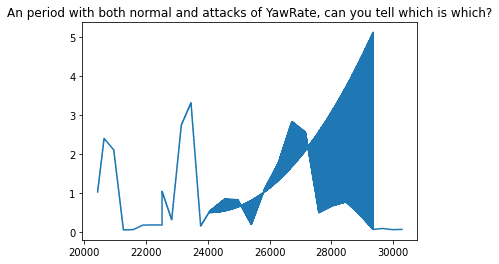

In [5]:
import matplotlib.pyplot as plt
df[(df.Timestamp >= 200) & (df.Timestamp <= 330)].YawRate.dropna().plot()
plt.title("An period with both normal and attacks of YawRate, can you tell which is which?")
plt.show()

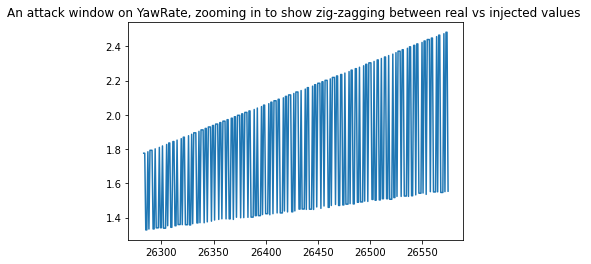

In [6]:
df[(df.Timestamp > 315) & (df.Timestamp < 316)].YawRate.dropna().plot()
plt.title("An attack window on YawRate, zooming in to show zig-zagging between real vs injected values ")
plt.show()

Let’s try a gradient-boosted trees firstly, e.g. sklearn’s HistGradientBoostingClassifier can work well on larger dataset before bringing out bigger guns.

In [14]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

gbc = HistGradientBoostingClassifier(max_iter=500).fit(df[FEATURES], df.Label == "Attack")

In [16]:
ypred = gbc.predict(df2[FEATURES])

cf = sklearn.metrics.confusion_matrix(df2.Label == "Attack", ypred)
print(sklearn.metrics.accuracy_score(df2.Label == "Attack", ypred))
print(cf)

print("Accuracy = %s " % sklearn.metrics.accuracy_score(df2.Label == "Attack", ypred))

0.8564686768659459
[[42191  1552]
 [ 5869  2091]]
Accuracy = 0.8564686768659459 


### 2c. Deep Learning and using a H1ST Model API, organizing, importing, saving & loading

We can bring out larger guns like Bidirectional LSTM or CNN or Transformers which can work well on pattern recognition problems on sequential data such as this one. One such model is available in the full tutorial source code package, and it can reach quite impressive accuracy.

Let's see how we could use it!

In [9]:
import h1st as h1
h1.init()

from AutomotiveCybersecurity.models.blstm_injection_msg_classifier import BlstmInjectionMsgClassifier

m = BlstmInjectionMsgClassifier()

A data-science project in H1ST.AI is designed to be a Python-importable package. You can create such a project using the `h1` command-line tool.

Organizing model code this way makes it easy to use as we will see. The Model API provides a unified workflow so that models can be used interactively in notebooks as well as in structured and complex projects as we shall see later.

Here, we call `h1.init()` to make sure we can import the package in our notebooks even when the package is not installed (as long as the notebooks are within the project folder structure).

It is a simple matter to import and train such organized `h1st.Model`, say on a small fraction of the data.

In [4]:
data = m.load_data(num_files=100)

prepared_data = m.prep(data)

m.train(prepared_data, epochs=10)

Epoch 1/10
     75/Unknown - 18s 246ms/step - loss: 0.4046 - accuracy: 0.8629
Epoch 00001: val_loss improved from inf to 0.38385, saving model to checkpoints/blstm_classif1.h5
75/75 [==============================] - 21s 274ms/step - loss: 0.4046 - accuracy: 0.8629 - val_loss: 0.3838 - val_accuracy: 0.8558
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8729
Epoch 00002: val_loss improved from 0.38385 to 0.37567, saving model to checkpoints/blstm_classif2.h5
75/75 [==============================] - 35s 467ms/step - loss: 0.3661 - accuracy: 0.8729 - val_loss: 0.3757 - val_accuracy: 0.8558
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8994
Epoch 00003: val_loss improved from 0.37567 to 0.21447, saving model to checkpoints/blstm_classif3.h5
75/75 [==============================] - 29s 393ms/step - loss: 0.2966 - accuracy: 0.8994 - val_loss: 0.2145 - val_accuracy: 0.9057
Epoch 4/10
75/75 [==================

As expected, powerful deep learning models can recognize these attack patterns well. (And we haven’t even trained the model on all the data and until fully converged.)

However, we must reckon that these models, after all, are recognizing attack patterns that humans are generating and injecting artificially. While this is convenient to generate output and train the detector program a la “Software 2.0”, for our situation, because the attacks are purely synthetic, we cannot be too sure that they are learning the right things and work robustly and can be trusted to deploy in the field. It’s best to employ them in the right deployment scope, namely useful pattern recognizers.